In [3]:
from dowhy import CausalModel
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [26]:
plt.rcParams["font.family"] = "서울한강 장체L"
river = pd("./project/data/all.xlsx")
print(river.shape)
river.info()

(270, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   측정소명                     270 non-null    object 
 1   2015                     270 non-null    int64  
 2   2016                     270 non-null    int64  
 3   2017                     270 non-null    int64  
 4   2018                     270 non-null    int64  
 5   2019                     270 non-null    int64  
 6   2020                     270 non-null    int64  
 7   미세먼지                     236 non-null    float64
 8   소매/음식/생활서비스              270 non-null    float64
 9   소매(범위)                   270 non-null    int64  
 10  음식(범위)                   270 non-null    int64  
 11  생활서비스(범위)                270 non-null    int64  
 12  합계 범위                    270 non-null    int64  
 13  교통량(양방)                  264 non-null    float64
 14  1km내 복원하천 여부    

In [43]:
def num_to_zone(x):
    if x in [1,2]:
        y = "주거지역"
    elif x == 3 :
        y = "상업지역"
    else:
        y = "공업지역"
    return (y)

In [27]:
# 1. 원핫 인코딩 생성
land_dummies = pd.get_dummies(river['합계 범위'])
restore_dummies= pd.get_dummies(river['1km내 복원하천 여부'])
river = pd.concat([river,land_dummies,restore_dummies],axis=1)

# 2. 변수 삭제
#river = river.drop(["합계 범위","1km내 복원하천 여부"],axis=1)

In [29]:
from matplotlib import font_manager, rc
font_path = "data/THEdog.ttf"   #폰트파일의 위치
font_name = font_manager.FontProperties(fname=font_path).get_name()
print(font_name)
rc('font', family=font_name)

THEGaeideuk


[Text(0.5, 1.0, '관측소별 녹지면적')]

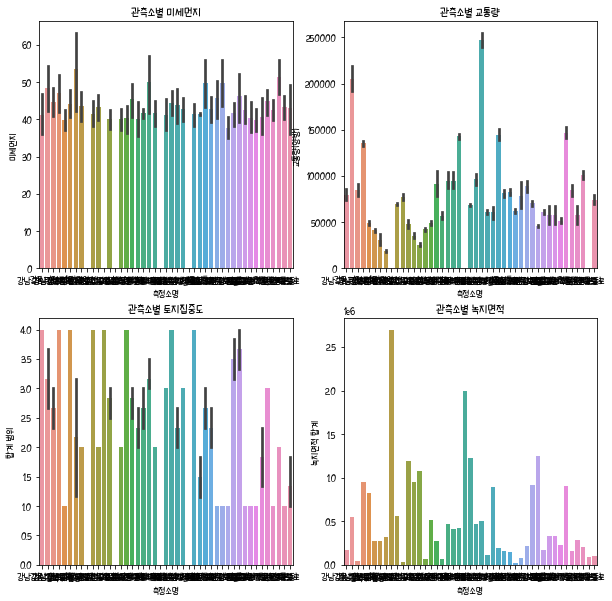

In [30]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
fig.set_size_inches(10,10)
sns.barplot(x="측정소명",y="미세먼지", data = river,ax=ax1)
sns.barplot(x="측정소명",y="교통량(양방)", data = river,ax=ax2)
sns.barplot(x="측정소명",y="합계 범위", data = river,ax=ax3)
sns.barplot(x="측정소명",y="녹지면적 합계", data = river,ax=ax4)
ax1.set(title = "관측소별 미세먼지")
ax2.set(title = "관측소별 교통량")
ax3.set(title = "관측소별 토지집중도")
ax4.set(title = "관측소별 녹지면적")

In [ ]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
fig.set_size_inches(10,10)

sns.boxplot(x="관측소",y="미세먼지", data = river,ax=ax1)
sns.boxplot(x="관측소",y="교통량", data = river,ax=ax2)
sns.boxplot(x="관측소",y="토지", data = river,ax=ax3)
sns.boxplot(x="관측소",y="녹지", data = river,ax=ax4)
ax1.set(title = "관측소별 미세먼지")
ax2.set(title = "관측소별 교통량")
ax3.set(title = "관측소별 토지집중도")
ax4.set(title = "관측소별 녹지면적")

In [ ]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.pointplot(data=river,x="관측소",y="미세먼지",ax=ax1)
sns.pointplot(data=river,x="관측소",y="미세먼지",hue="교통량",ax=ax2)
sns.pointplot(data=river,x="관측소",y="미세먼지",hue="토지이용",ax=ax3)
sns.pointplot(data=river,x="관측소",y="미세먼지",hue="녹지면적",ax=ax4)
sns.pointplot(data=river,x="관측소",y="미세먼지",hue="복원하천유무",ax=ax5)

In [38]:
river["is_restore"]=river["1km내 복원하천 여부"].apply(lambda x: True if x == 1 else False)
#river["is_ready"]=river["복원하천 면적"].apply(lambda x: True if x == 0 else False)
#river["is_토지이용"]=river["토지종"].apply(lambda x: True if (x=="상업지구") or (x=="준공업지구")  else False)
#river["is_2017"] = river["year"].apply(lambda x: True if x==2017 else False)

In [40]:
restore_effect = CausalModel(
    data=river,
    treatment = "is_restore",
    outcome = "미세먼지",
    common_causes = "교통량(양방)+합계 범위+녹지면적 합계+2015".split("+"))

restore_identified = restore_effect.identify_effect()

restore_matching = restore_effect.estimate_effect(restore_identified,method_name = "backdoor.propensity_score_matching")
restore_stratify = restore_effect.estimate_effect(restore_identified,method_name = "backdoor.propensity_score_stratification")

print("Causal Estimate of Matching: {}".format(restore_matching.value))
print("Causal Estimate of Stratification: {}".format(restore_stratify.value))

WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n]  y


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
#모디파이어 고려(트리트먼트와 결과에 동시에 영향을 주는 요소)
mass_effect = CausalModel(
    data=river,
    treatment = "복원하천면적",
    outcome   = "미세먼지",
    common_causes = "교통량+녹지면적+토지이용+시간더미".split("+"),
    effect_modifiers = "하천폭".split("+"))

mass_identified = mass_effect.identify_effect()

mass_matching = mass_effect.estimate_effect(mass_identified,method_name = "backdoor.propensity_score_matching")
mass_stratify = mass_effect.estimate_effect(mass_identified,method_name = "backdoor.propensity_score_stratification")

print("Causal Estimate of Matching: {}".format(mass_matching.value))
print("Causal Estimate of Stratification: {}".format(mass_stratify.value))

In [ ]:
# 1. 무관한 교란변수 생성
restore_random    = restore_effect.refute_estimate(restore_identified, restore_matching,method_name="random_common_cause")
# 2. 가짜 처리 생성
restore_placebo   = restore_effect.refute_estimate(restore_identified, restore_matching,method_name="placebo_treatment_refuter", placebo_type="permute")
# 3. 일부만 추출(서브셋 변경할것)
restore_subset    = restore_effect.refute_estimate(restore_identified, restore_matching,method_name="data_subset_refuter", subset_fraction=0.8)

restore_random_str    = restore_effect.refute_estimate(restore_identified, restore_stratify,method_name="random_common_cause")
restore_placebo_str   = restore_effect.refute_estimate(restore_identified, restore_stratify,method_name="placebo_treatment_refuter", placebo_type="permute")
restore_subset_str    = restore_effect.refute_estimate(restore_identified, restore_stratify,method_name="data_subset_refuter", subset_fraction=0.8)

In [ ]:
print(restore_random)
print(restore_placebo)
print(restore_subset)

print(restore_random_str)
print(restore_placebo_str)
print(restore_subset_str)